# Sweet Lift Taxi Prediction Model

## Introduction
The Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the number of taxi orders for the next hour. Build a model for this prediction. The RMSE metric on the test set must not exceed 48.

The data of the _.csv_ file is the follwing:
- The data is stored in the file taxi.csv.
- The number of orders is in the column num_orders.

## 1. Data exploration and preprocessing

### 1.1. Libreries initialization

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder



### 1.2. Data loading

In [2]:
file_path = os.path.join("datasets", "taxi.csv")

# Cargar el DataFrame
df = pd.read_csv(file_path)

# Convertir los nombres de las columnas a minúsculas
df.columns = df.columns.str.lower()

# Muestra aleatoria de 10 filas
df.sample(10)


,datetime,num_orders
19445,2018-07-14 00:50:00,24
15592,2018-06-17 06:40:00,2
18877,2018-07-10 02:10:00,19
22680,2018-08-05 12:00:00,8
9173,2018-05-03 16:50:00,12
15342,2018-06-15 13:00:00,6
24114,2018-08-15 11:00:00,25
18652,2018-07-08 12:40:00,19
23853,2018-08-13 15:30:00,19
13589,2018-06-03 08:50:00,11


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df["datetime"] = pd.to_datetime(df["datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
df.set_index("datetime", inplace=True)
df_resampled = df.resample("1H").sum()
print(df_resampled.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


/var/folders/y_/4wwc4n5d2b70xpd8w5t_sk3m0000gn/T/ipykernel_4688/12828507.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample("1H").sum()


### 1.3. Data descriptive exploration

In [6]:
df_resampled.describe().round()

,num_orders
count,4416.0
mean,84.0
std,45.0
min,0.0
25%,54.0
50%,78.0
75%,107.0
max,462.0


In order to visualize the data, we can plot the number of orders during the months:

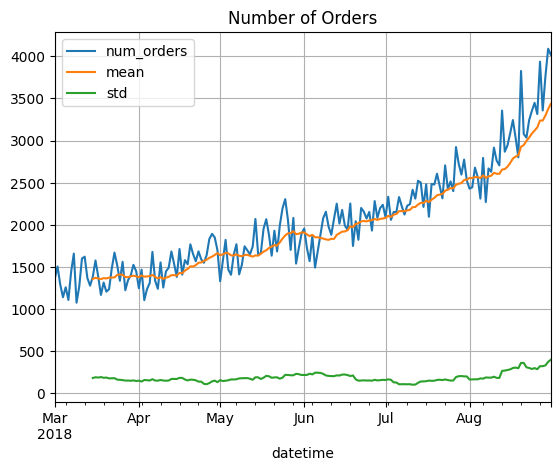

In [7]:
data = df.resample('1D').sum()
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot()

plt.title("Number of Orders")  
plt.grid(True)  
plt.show()

We can graph the variations using _shift_:

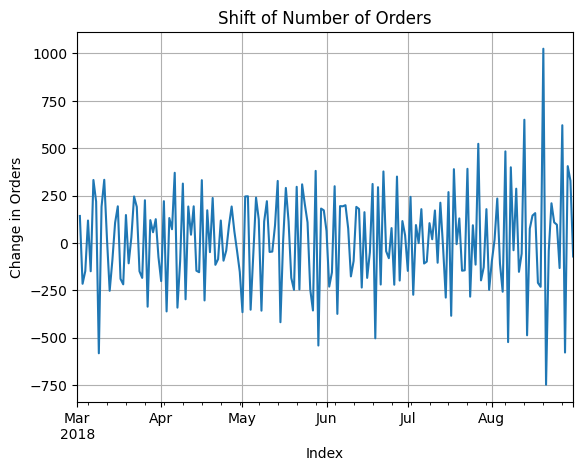

In [8]:
data['shift'] = data['num_orders'] - data['num_orders'].shift()
data['shift'].plot()
plt.title("Shift of Number of Orders")  
plt.xlabel("Index")  
plt.ylabel("Change in Orders")  
plt.grid(True)  
plt.show()


## 2. Model Trainning

For this section, we are going to try different models in order to choose the best model configuration. The models we are testing are:

- Linear Regression 
- Decision Tree
- Random Forest 

The criteria of the election is:

- Prediction quality  
- Prediction speed  
- Training time

In [9]:
df = df_resampled

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data["hour"] = data.index.hour
    

  
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(window = rolling_mean_size).mean()
    return data

max_lag = 10
df = make_features(df, max_lag = max_lag, rolling_mean_size=10)


lag_features = [f'lag_{i}' for i in range(1, max_lag + 1)] 
features = ["dayofweek", "month", "year", "rolling_mean"] + lag_features

if "hour" in df.columns:
    features.insert(0, "hour")

X = df[features].dropna()
y = df["num_orders"].loc[X.index]  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

print(X.head())






                     hour  dayofweek  month  year  rolling_mean  lag_1  lag_2  \
datetime                                                                        
2018-03-01 10:00:00    10          3      3  2018          52.5   69.0   34.0   
2018-03-01 11:00:00    11          3      3  2018          46.5   64.0   69.0   
2018-03-01 12:00:00    12          3      3  2018          47.6   96.0   64.0   
2018-03-01 13:00:00    13          3      3  2018          43.5   30.0   96.0   
2018-03-01 14:00:00    14          3      3  2018          40.1   32.0   30.0   

                     lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  
datetime                                                                      
2018-03-01 10:00:00   15.0   12.0    6.0   43.0   66.0   71.0   85.0   124.0  
2018-03-01 11:00:00   34.0   15.0   12.0    6.0   43.0   66.0   71.0    85.0  
2018-03-01 12:00:00   69.0   34.0   15.0   12.0    6.0   43.0   66.0    71.0  
2018-03-01 13:00:00   64.0   69.0   3

In [10]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start_pred

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse, train_time, pred_time

# 1. Linear Regression
lr = LinearRegression()
lr_rmse, lr_train_time, lr_pred_time = evaluate_model(lr, X_train, X_test, y_train, y_test)
print(f"Linear Regression -> RMSE: {lr_rmse:.4f}, Train Time: {lr_train_time:.4f} sec, Pred Time: {lr_pred_time:.4f} sec")

# 2. Decision Tree
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_rmse, dt_train_time, dt_pred_time = evaluate_model(dt, X_train, X_test, y_train, y_test)
print(f"Decision Tree -> RMSE: {dt_rmse:.4f}, Train Time: {dt_train_time:.4f} sec, Pred Time: {dt_pred_time:.4f} sec")

# 3. Random Forest
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_rmse, rf_train_time, rf_pred_time = evaluate_model(rf, X_train, X_test, y_train, y_test)
print(f"Random Forest -> RMSE: {rf_rmse:.4f}, Train Time: {rf_train_time:.4f} sec, Pred Time: {rf_pred_time:.4f} sec")


Linear Regression -> RMSE: 54.2161, Train Time: 0.0278 sec, Pred Time: 0.0020 sec
Decision Tree -> RMSE: 48.6609, Train Time: 0.0448 sec, Pred Time: 0.0020 sec
Random Forest -> RMSE: 46.3976, Train Time: 0.3448 sec, Pred Time: 0.0287 sec


In [11]:
df_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'RMSE': [lr_rmse, dt_rmse, rf_rmse],
    'Training Time (s)': [lr_train_time, dt_train_time, rf_train_time],
    'Prediction Time (s)': [lr_pred_time, dt_pred_time, rf_pred_time]
})

df_results['Total Time (s)'] = df_results['Training Time (s)'] + df_results['Prediction Time (s)']

print(df_results.sort_values(by='RMSE'))

               Model       RMSE  Training Time (s)  Prediction Time (s)  \
2      Random Forest  46.397561           0.344784             0.028750   
1      Decision Tree  48.660920           0.044795             0.001961   
0  Linear Regression  54.216132           0.027787             0.001951   

   Total Time (s)  
2        0.373534  
1        0.046756  
0        0.029738  


# Conclusion

The best model for this group of data it's Random Forest because it has a good overall performance (RMSE < 48) and the good prediction Time. 